In [ ]:
pip install scanpy

In [ ]:
pip install igraph

In [ ]:
pip install louvain

In [2]:
import pickle
import numpy as np
import pandas as pd

import scanpy as sc
import anndata
import random

import torch
#from etm import ETM
from torch import optim
from torch.nn import functional as F

import os
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from seaborn import heatmap, lineplot, clustermap

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
import torch.nn.functional as F 
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size,
                    theta_act, embeddings=None, train_embeddings=True, enc_drop=0.5):
        super(ETM, self).__init__()


        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.t_hidden_size = t_hidden_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.t_drop = nn.Dropout(enc_drop)

        self.theta_act = self.get_activation(theta_act)

        self.train_embeddings = train_embeddings        
        
        ## define the word embedding matrix \rho
        if self.train_embeddings:
            self.rho = nn.Parameter(torch.randn(vocab_size, rho_size)) # V x L
        else:
            self.rho = embeddings.clone().float().to(device) # V x L

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)#nn.Parameter(torch.randn(rho_size, num_topics))
    
        ## define variational distribution for \theta_{1:D} via amortizartion
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size), 
                self.theta_act,
                nn.Linear(t_hidden_size, t_hidden_size),
                self.theta_act,
            )
        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def get_activation(self, act):
        if act == 'tanh':
            act = nn.Tanh()
        elif act == 'relu':
            act = nn.ReLU()
        elif act == 'softplus':
            act = nn.Softplus()
        elif act == 'rrelu':
            act = nn.RReLU()
        elif act == 'leakyrelu':
            act = nn.LeakyReLU()
        elif act == 'elu':
            act = nn.ELU()
        elif act == 'selu':
            act = nn.SELU()
        elif act == 'glu':
            act = nn.GLU()
        else:
            print('Defaulting to tanh activations...')
            act = nn.Tanh()
        return act 

    # theta ~ mu + std N(0,1)
    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar) 
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)

        # KL[q(theta)||p(theta)] = lnq(theta) - lnp(theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()
        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):
        ## softmax over vocab dimension
        beta = F.softmax(self.alphas(self.rho), dim=0).transpose(1, 0)
        return beta

    def get_theta(self, normalized_bows):
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1) 
        return theta, kld_theta

    def decode(self, theta, beta):
        res = torch.mm(theta, beta)
        preds = torch.log(res+1e-6)
        return preds 

    def forward(self, X, X_normalized, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            theta, kld_theta = self.get_theta(X_normalized)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * X).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta

In [6]:
random.seed(10)

# mouse pancreas single-cell dataset
# read in data and cell type labels
with open('/content/gdrive/My Drive/COMP 565/MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open('/content/gdrive/My Drive/COMP 565/MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)

df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open('/content/gdrive/My Drive/COMP 565/cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

In [7]:
df

,0610009E02Rik,0610010K14Rik,1110002L01Rik,1110008F13Rik,1110020A21Rik,1110051M20Rik,1190002N15Rik,1190007I07Rik,1500004A13Rik,1500009L16Rik,...,Zranb3,Zrsr1,Zscan22,Zswim7,Zw10,Zxdc,Zzef1,Zzz3,batch,assigned_cluster
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
mouse2_lib1.final_cell_0052,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1,beta
mouse2_lib3.final_cell_0069,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ductal
mouse2_lib1.final_cell_0300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,beta
mouse1_lib2.final_cell_0097,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,beta
mouse1_lib1.final_cell_0196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,beta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse2_lib1.final_cell_0179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,beta
mouse2_lib3.final_cell_0351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,beta
mouse2_lib2.final_cell_0286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,delta


In [8]:
X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv('/content/gdrive/My Drive/COMP 565/sample_info.csv')

mp_anndata = anndata.AnnData(X=X)

mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values

N = X.shape[0]  # number of single-cell samples
K = 16  # number of topics
M = X.shape[1]  # number of genes

In [9]:
N, K, M

(1886, 16, 4194)

In [10]:
def evaluate_ari(cell_embed, adata):
    """
        This function is used to evaluate ARI using the lower-dimensional embedding
        cell_embed of the single-cell data
        :param cell_embed: a NxK single-cell embedding generated from NMF or scETM
        :param adata: single-cell AnnData data object (default to to mp_anndata)
        :return: ARI score of the clustering results produced by Louvain
    """
    adata.obsm['cell_embed'] = cell_embed
    sc.pp.neighbors(adata, use_rep="cell_embed", n_neighbors=30)
    sc.tl.louvain(adata, resolution=0.15)
    ari = adjusted_rand_score(adata.obs['Celltype'], adata.obs['louvain'])
    return ari



# Question 1

In [ ]:
######## Q1 NMF sum of squared error ########
W_init = np.random.random((M, K))
H_init = np.random.random((K, N))


# Complete this function
def nmf_sse(X, W, H, adata=mp_anndata, niter=100):
    """
        NMF with sum of squared error loss as the objective
        :param X: M x N input matrix
        :param W: M x K basis matrix
        :param H: K x N coefficient matrix
        :param adata: annotated X matrix with cluster labels for evaluating ARI (default to mouse pancreas data)
        :param niter: number of iterations to run
        :return:
            1. updated W and H that minimize sum of squared error ||X - WH||^2_F s.t. W,H>=0
            2. niter-by-3 ndarray with iteration index, SSE, and ARI as the 3 columns
    """
    #random.seed(10)
    perf = np.ndarray(shape=(niter, 3), dtype='float')

    # WRITE YOUR CODE HERE
    for i in range(niter):
        H = H * (np.matmul(W.T, X)) / (np.matmul(W.T, np.matmul(W, H)))
        W = W * (np.matmul(X, H.T)) / (np.matmul(W, np.matmul(H, H.T)))
        mse = np.sum(np.square(X-np.matmul(W, H))) / (N*M)
        ari = evaluate_ari(H.T, adata)
        perf[i]= [i, mse, ari]
        print("iteration: ", i+1, "mse_loss: ", mse, "ARI: ", ari)

    return W, H, perf


W_nmf_sse, H_nmf_sse, nmf_sse_perf = nmf_sse(X.T, W_init, H_init, niter=100)

# Question 2

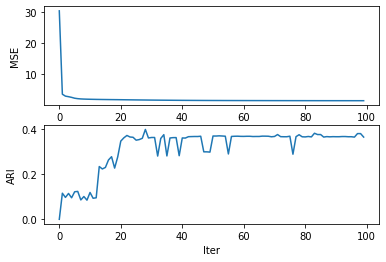

In [18]:
######## Q2: write a function to monitor ARI and objective function ########
def monitor_perf(perf, objective, path=""):
    """
    :param perf: niter-by-3 ndarray with iteration index, objective function, and ARI as the 3 columns
    :param objective: 'SSE', 'Poisson', or 'NELBO'
    :param path: path to save the figure if not display to the screen
    :behaviour: display or save a 2-by-1 plot showing the progress of optimizing objective and ARI as
        a function of iterations
    """

    # WRITE YOUR CODE HERE
    fig, axes = plt.subplots(2,1)
    axes[0].plot(perf[:, 0], perf[:, 1])
    axes[0].set(xlabel="Iter", ylabel=objective)
    axes[1].plot(perf[:, 0], perf[:, 2])
    axes[1].set(xlabel="Iter", ylabel="ARI")
    #plt.savefig(path)
    plt.show()
    


monitor_perf(nmf_sse_perf, "MSE", 'figures/nmf_sse.eps')

# Question 3

In [21]:
H_init.T.shape

(1886, 16)

In [22]:
X.T.shape

(4194, 1886)

In [23]:
W_init.shape

(4194, 16)

In [ ]:
######## Q3 NMF Poisson likelihood ########
# NMF with Poisson likelihood
# Complete this function
def nmf_psn(X, W, H, adata=mp_anndata, niter=100):
    """
        NMF with log Poisson likelihood as the objective
        :param X.T: M x N input matrix
        :param W: M x K basis matrix
        :param H: K x N coefficient matrix
        :param niter: number of iterations to run
        :return:
            1. updated W and H that minimize sum of squared error ||X - WH||^2_F s.t. W,H>=0
            2. niter-by-3 ndarray with iteration index, SSE, and ARI as the 3 columns
    """
    perf = np.ndarray(shape=(niter, 3), dtype='float')

    # WRITE YOUR CODE HERE
    W = np.where(W>0, W, 1e-16)
    H = np.where(H>0, H, 1e-16)
    W[W <= 0] = 1e-16
    H[H <= 0] = 1e-16

    for i in range(niter):
        one = np.ones((M, N)) # 4196 * 1886

        # update W
        num_W = np.matmul(X/np.matmul(W, H), H.T) # 4194 * 16
        #print(num_W.shape)
        denom_W = np.matmul(one, H.T) # 4194 * 16
        #print((num_W/denom_W).shape)
        #W = np.matmul(W, num_W/denom_W) 
        W = W*(num_W/denom_W) 
        
        # update H
        num_H = np.matmul(W.T, X/np.matmul(W, H))
        denom_H = np.matmul(W.T, one)
        #H = np.matmul(H, num_H/denom_H)
        H = H*(num_H/denom_H) 

        # W = W + (W / np.matmul(one, H.T)) * (np.matmul(X / np.matmul(W, H), H.T) - np.matmul(one, H.T))
        # H = H + (H / np.matmul(W.T, one)) * (np.matmul(W.T, X / np.matmul(W, H)) - np.matmul(W.T, one))
        
        W = np.where(W>0, W, 1e-16)
        H = np.where(H>0, H, 1e-16)
        W[W <= 0] = 1e-16
        H[H <= 0] = 1e-16

        poisson = np.sum(X * np.log(np.matmul(W, H)) - np.matmul(W, H)) / (N * M)
        ari = evaluate_ari(H.T, adata)
        perf[i]= [i, poisson, ari]
        print("iteration: ", i+1, "psn_loss: ", poisson, "ARI: ", ari)


    return W, H, perf


W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, W_init, H_init, niter=100)

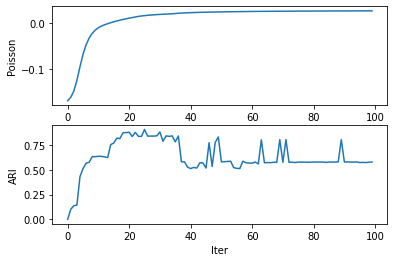

In [30]:
monitor_perf(nmf_psn_perf, "Poisson", 'figures/nmf_psn.eps')

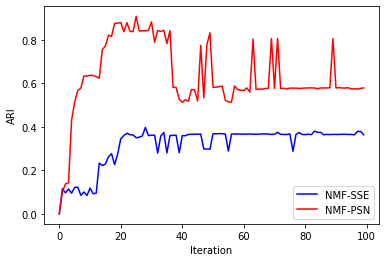

In [31]:
# compare NMF-SSE and NMF-Poisson
# W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, W_init, H_init, niter=1000)
# W_nmf_sse, H_nmf_sse, nmf_sse_perf = nmf_sse(X.T, W_init, H_init, niter=1000)
fig, ax = plt.subplots()
nmf_sse_perf_df = pd.DataFrame(data=nmf_sse_perf, columns=['Iter', "SSE", 'ARI'])
nmf_psn_perf_df = pd.DataFrame(data=nmf_psn_perf, columns=['Iter', "Poisson", 'ARI'])
ax.plot(nmf_sse_perf_df["Iter"], nmf_sse_perf_df["ARI"], color='blue', label='NMF-SSE')
ax.plot(nmf_psn_perf_df["Iter"], nmf_psn_perf_df["ARI"], color='red', label='NMF-PSN')
ax.legend()
plt.xlabel("Iteration")
plt.ylabel("ARI")
#plt.savefig("figures/nmf_sse_vs_psn.eps")
plt.show()

# Question 4

In [34]:
######## Q4-Q8 VAE single-cell embedded topic model ########
X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ETM(num_topics=K,
            vocab_size=len(genes),
            t_hidden_size=256,
            rho_size=256,
            theta_act='relu',
            embeddings=None,
            train_embeddings=True,
            enc_drop=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)


# train the VAE for one epoch
def train_scETM_helper(model, X_tensor, X_tensor_normalized):
    # initialize the model and loss
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    # forward and backward pass
    nll, kl_theta = model(X_tensor, X_tensor_normalized)
    loss = nll + kl_theta
    loss.backward()  # backprop gradients w.r.t. negative ELBO

    # clip gradients to 2.0 if it gets too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    # update model to minimize negative ELBO
    optimizer.step()

    return torch.sum(loss).item()


# get sample encoding theta from the trained encoder network
def get_theta(model, input_x):
    model.eval()
    with torch.no_grad():
        q_theta = model.q_theta(input_x)
        mu_theta = model.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta


######## Q4 complete this function ########
def train_scETM(model, X_tensor, X_tensor_normalized, adata=mp_anndata, niter=1000):
    """
        :param model: the scETM model object
        :param X_tensor: NxM raw read count matrix X
        :param X_tensor_normalized: NxM normalized read count matrix X
        :param adata: annotated single-cell data object with ground-truth cell type information for evaluation
        :param niter: maximum number of epochs
        :return:
            1. model: trained scETM model object
            2. perf: niter-by-3 ndarray with iteration index, SSE, and ARI as the 3 columns
    """
    perf = np.ndarray(shape=(niter, 3), dtype='float')

    # WRITE YOUR CODE HERE
    for i in range(niter):
        
        loss = train_scETM_helper(model, X_tensor, X_tensor_normalized)
        theta = get_theta(model, X_tensor_normalized)
        
        with torch.no_grad():
            ari = evaluate_ari(theta, adata)
        perf[i] = [i, loss, ari]

        print("iteration: ", i+1, "scETM_loss: ", loss, "ARI: ", ari)


    return model, perf


model, scetm_perf = train_scETM(model, X_tensor, X_tensor_normalized)

RuntimeError: ignored

In [ ]:
monitor_perf(scetm_perf, "NELBO", 'figures/scETM_train.eps')